In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torchvision import models, datasets

from data_utils.data_setup import get_imagenet_test, get_top_prediction, get_imagenet_classes
from techniques.gen_patch import gen_adversarial_patch
from metrics.utils import *
from techniques.generate_grounding import gen_grounding

datadir = '../data/test/'
#datadir = '../data/ILSVRC2012_img_val/'
save_path='../results/explanation_examples/'

## ImageNet Test Set

In [30]:
import json

# find class label given folder name
def find_label(target):
    with open('../data/imagenet_class_index.json', 'r') as f:
        labels = json.load(f)
    for key in labels:
        index, label = labels[key]
        if index == target:
            return label, key
    
# get dataloader and folder names (classes)
dataset, data_loader = get_imagenet_test(datadir=datadir, shuffle=True)
labels = list(os.walk(datadir))[0][1]
list.sort(labels)

## Generate/Explain Image

tensor([11])
ground truth class: cuirass
getting model   vgg19
predicted clas: cuirass
tensor([14])
ground truth class: mixing_bowl
getting model   vgg19
predicted clas: gong
correct classification


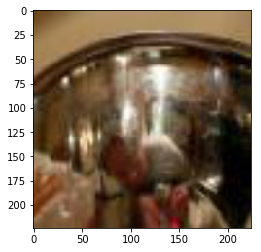

In [31]:
j=0
for i, (inp, label) in enumerate(data_loader):
    if j<1:
        print(label)
        gt_label = labels[label.numpy()[0]]
        gt_label_name, gt_label_idx = find_label(gt_label)
        print('ground truth class: {0}'.format(gt_label_name))
        img = inp[0].numpy().transpose((1, 2, 0))
        label_name = get_imagenet_classes()[label.numpy()[0]]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        displ_img = std * img + mean
        displ_img = np.clip(displ_img, 0, 1)
        displ_img /= np.max(displ_img)
        patch_img = displ_img
        displ_img = np.uint8(displ_img*255)
        label_name, label_idx = get_top_prediction('vgg19', inp.cuda())
        print('predicted clas: {0}'.format(label_name))
        if label_name != gt_label_name:
            print('correct classification')
            plt.imshow(displ_img)
            j+=1
            break
    else:
        break
    

# Mask/Heatmap Methods

### Grad-Cam

result path: ../results/explanation_examples/mixing_bowl/
[0.32696] shield
finished gradcam explanation
saving explanation mask

saved to ../results/explanation_examples/mixing_bowl/gcam-resnet18
------------------------------


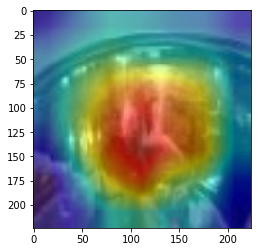

In [32]:
gcam_expl = gen_grounding(displ_img, 'gcam', gt_label_name, show=True, save=True, save_path=save_path, index=1)
#gcam_expl2 = gen_grounding(displ_img, 'gcam', gt_label_name, show=True, save=True, save_path=save_path, index=2)

In [17]:
#new_expl = gcam_expl-gcam_expl2
#new_expl[new_expl < 0] = 0


ValueError: operands could not be broadcast together with shapes (224,224,3) (224,224) 

### LIME

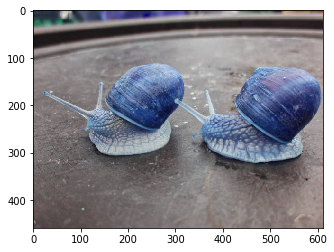

In [95]:
lime_expl, lime_mask = gen_grounding(displ_img, 'vgg19', 'lime', gt_label_name, show=True, save=True, save_path=save_path, label_index=i)

result path: ../results/explanation_examples/golden_retriever/golden_retriever0/
original lime classification: golden_retriever
lime classsification: 644
finished lime explanation
------------------------------


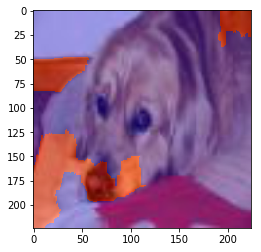

In [32]:
lime_expl = gen_grounding(displ_img, 'vgg19', 'lime', gt_label_name, show=True, save=False, save_path=save_path, label_index=i)

### RISE

In [ ]:
rise_expl, rise_mask = gen_grounding(displ_img, 'vgg19', 'rise', gt_label_name, show=True, save_path=save_path, label_index=i)

# Saliency Methods

### Integrated Gradients

result path: ../results/explanation_examples/golden_retriever/golden_retriever0/
integrated gradients clasification: golden_retriever


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


finished Integrated Gradients explanation
saving explanation mask

saved to ../results/explanation_examples/golden_retriever/golden_retriever0/ig-vgg19
------------------------------


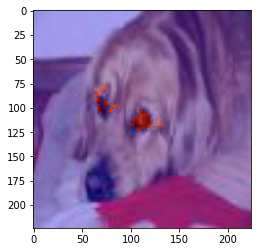

In [33]:
#displ_img = cv2.imread('../data/examples/03.jpg')
#displ_img = cv2.resize(displ_img, (224, 224))
ig_expl = gen_grounding(displ_img, 'vgg19', 'ig', gt_label_name, show=True, save_path=save_path, label_index=i)

result path: ../results/explanation_examples/white_car/white_car1/
integrated gradients clasification: convertible


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


finished Integrated Gradients explanation
saving explanation mask

saved to ../results/explanation_examples/white_car/white_car1/ig-vgg19
------------------------------


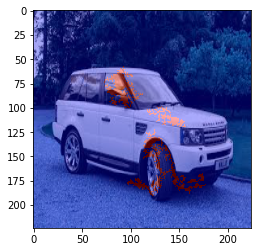

In [17]:
displ_img = cv2.imread('../data/samples/white_car.jpg')
displ_img = cv2.resize(displ_img, (224, 224))
ig_expl = gen_grounding(displ_img, 'vgg19', 'ig', 'white_car', show=True, save_path=save_path, label_index=i)

# Get Stats

In [56]:
iou_pix, cos_dist, js_dist, tvd, cc = get_stats(np.float32(ig_mask), lime_mask, threshold=10)

pixel count IoU: 0.004022191400832178
cos similarity: 0.8182256808217385
Jenson Shannon dist: 0.7215742216816708
total variation distance: 0.9933854557551773
Pearsons Correlation Coefficient: -0.05971653644705394
------------------------------


## Calculate IoU

In [ ]:
from techniques.utils import calc_iou, weight_mask

In [ ]:
iou, intersection, union = calc_iou(gcam_mask, lime_mask, threshold=50, num_pixels=True)
print("IoU pixel value sum: {0}".format(iou))

#### Check IoU

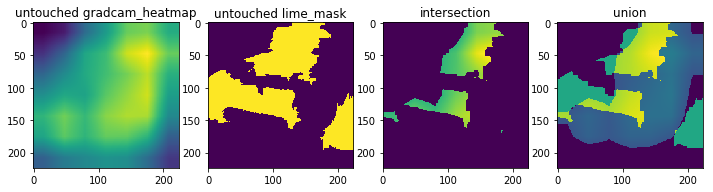

In [87]:
_, axs = plt.subplots(1, 4, figsize=(12, 12))
axs = axs.flatten()
imgs = [gcam_mask, lime_mask, intersection, union]
labels = ['untouched gradcam_heatmap', 'untouched lime_mask', 'intersection', 'union']
for img, ax, label in zip(imgs, axs, labels):
    ax.set_title(label)
    ax.imshow(img)
plt.show()